# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
!pip3 install torchvision

#Check that the correct PIL version is installed
import PIL
print(PIL.PILLOW_VERSION)

#In case there are incomptability errors, reinstall Pillow
if PIL.PILLOW_VERSION != '5.3.0':
  print('Reinstalling PIL')
  !pip uninstall -y Pillow
  !pip install Pillow==5.3.0

#If PIL.PILLOW_VERSION is 4.0.0 after reinstalling Pillow, then restart runtime

5.3.0


In [2]:
#Resolve incompatbility issue with CUDA on Colab
!pip3 install torchvision
print('')
  
import torch
print('Checking CUDA device')
torch.cuda.get_device_name(0)


Checking CUDA device


'Tesla K80'

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
# Imports here
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F
import copy
from PIL import Image
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
import datetime
import torchvision
import PIL
from matplotlib.ticker import FormatStrFormatter

## Testing for CUDA

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Mount Google Drive to Google's Linux VM (Colab)

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
#Check whether Google Drive is connected

with open('/gdrive/My Drive/test.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/test.txt'

Hello Google Drive!

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [8]:
!wget -qq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
  
!unzip -qq flower_data.zip
!rm flower_data.zip

!ls

flower_data  sample_data


In [9]:
!git clone https://github.com/udacity/pytorch_challenge.git

Cloning into 'pytorch_challenge'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), done.


In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
#Transforms for the training, validation, and testing sets
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]),
    'validation':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])}

#Load the datasets with ImageFolder
image_datasets = {
    'train':
        datasets.ImageFolder(train_dir, data_transforms['train']),
    'validation':
        datasets.ImageFolder(valid_dir, data_transforms['validation'])}

#Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=40,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=40,
            shuffle=False,
            num_workers=4)}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

location = 'pytorch_challenge/'

with open(location + 'cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
#Choose the pretrained model that you would like to use 
model = models.resnet152(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False
 

model.fc = nn.Sequential(
    nn.Linear(2048, 4096),
    nn.ReLU(inplace=True),
    #nn.Dropout(0.2),
    #nn.Linear(2048, 2048),
    #nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(4096,102)).to(device)
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.00002)

#Try using lr_scheduler to improve the accuracy
#scheduler = lr_scheduler.StepLR(optimizer,30,gamma=0.9)
scheduler = None

#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:03, 75405626.89it/s]


In [0]:
#Load model checkpoint so that we don't have to re-run the training
model.load_state_dict(torch.load('/gdrive/My Drive/Deep Learning Workshop/resnet152.h5'))

FileNotFoundError: ignored

In [0]:
#Model FileName
#file_name = '/gdrive/My Drive/Deep Learning Workshop/best_model_weights.h5'
file_name = '/gdrive/My Drive/Deep Learning Workshop/090119_resnet152.h5'

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  
  min_validation_loss = np.Inf
  min_validation_acc = 0
  
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)

      for phase in ['train', 'validation']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              
              inputs = inputs.cuda().to(device)
              labels = labels.cuda().to(device)
              
              outputs = model(inputs)
              loss = criterion(outputs, labels)
                
              if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  if scheduler:  
                    scheduler.step()
                  else:
                    optimizer.step()

              _, preds = torch.max(outputs, 1)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(image_datasets[phase])
          epoch_acc = running_corrects.double() / len(image_datasets[phase])

          print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                      epoch_loss,
                                                      epoch_acc))
          print('')

          if (phase == 'validation') & (float(epoch_loss) < min_validation_loss) & (float(epoch_acc) > min_validation_acc):
            
            #Update min_validation_loss and min_validation_acc if both validation accuracy and validation loss improves 
            min_validation_loss = float(epoch_loss)
            min_validation_acc = float(epoch_acc)
            
            #Save the model weights if both validation accuracy and validation loss improves 
            torch.save(model.state_dict(), file_name)
            print('Model validation loss < previous model. Model saved')
            print('')

  return model

For debugging

def train_model(model, criterion, optimizer, scheduler, num_epochs):
  
  min_validation_loss = np.Inf
  min_validation_acc = 0
  
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)

      for phase in ['train', 'validation']:
          if phase == 'train':
              model.train()
          else:
              model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              
              inputs = inputs.cuda().to(device)
              labels = labels.cuda().to(device)
              
              print(labels)
              print('-' * 100)
              
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              
              print(outputs)
              print('-' * 100)
              
                
              '''if phase == 'train':
                  optimizer.zero_grad()
                  loss.backward()
                  if scheduler:  
                    scheduler.step()
                  else:
                    optimizer.step()

              _, preds = torch.max(outputs, 1)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(image_datasets[phase])
          epoch_acc = running_corrects.double() / len(image_datasets[phase])

          print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                      epoch_loss,
                                                      epoch_acc))
          print('')

          if (phase == 'validation') & (float(epoch_loss) < min_validation_loss) & (float(epoch_acc) > min_validation_acc):
            
            #Update min_validation_loss and min_validation_acc if both validation accuracy and validation loss improves 
            min_validation_loss = float(epoch_loss)
            min_validation_acc = float(epoch_acc)
            
            #Save the model weights if both validation accuracy and validation loss improves 
            torch.save(model.state_dict(), file_name)
            print('Model validation loss < previous model. Model saved')
            print('')'''

  return model

In [18]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=1000)

Epoch 1/1000
----------
tensor([ 56,  45,  97,  45,  46,  84,  16,  64,  83, 100,  93,  33,  19,   7,
         77,  85,  48,  92,  71,  57,  31,  72,  41, 100,  49,  74,  66,  62,
         36,   5,  90,   6,  65,  81, 101,  41,  24,  78,  74,  78],
       device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[-0.0831, -0.1140, -0.1645,  ..., -0.3424, -0.1876, -0.0893],
        [ 0.1459,  0.1618,  0.0237,  ..., -0.2978, -0.4204, -0.0636],
        [-0.1000, -0.1098, -0.0319,  ..., -0.4330, -0.3188,  0.0129],
        ...,
        [ 0.0104,  0.0537,  0.0300,  ..., -0.3208, -0.1757,  0.1658],
        [-0.0468,  0.0390, -0.1650,  ..., -0.4708, -0.2042,  0.0517],
        [-0.1399,  0.1096,  0.0556,  ..., -0.2104, -0.1547, -0.0487]],
       device='cuda:0', grad_fn=<AddmmBackward>)
----------------------------------------------------------------------------------------------------
tensor([11,  6, 99, 90, 19, 46, 11,  2, 49

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self

KeyboardInterrupt: ignored

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
#Save the checkpoint 

#Save the model parameters
model.class_to_idx = train_data.class_to_idx

torch.save({'structure' :'resnet152',
            'hidden_layer': [400, 400, 400]
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx},
            'checkpoint.pth')

#Save the model weights (again)
torch.save(model_trained.state_dict(),'/gdrive/My Drive/Deep Learning Workshop/resnet152_model_weights.h5')

print('Model saved in', '/gdrive/My Drive/Deep Learning Workshop/resnet152_model_weights.h5')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
def load_model(path):
  checkpoint = torch.load('checkpoint.pth')
  structure = checkpoint['structure']
  model.class_to_idx = checkpoint['class_to_idx']
  model.load_state_dict(checkpoint['state_dict'])

In [0]:
model.load_state_dict(torch.load('/gdrive/My Drive/Deep Learning Workshop/resnet152_model_weights.h5'))

print(model)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        after which it returns a Numpy array
    '''
    
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor

In [0]:
!ls -al flower_data/valid/1

total 368
drwxr-xr-x   2 root root  4096 Jan 15  2018 .
drwxr-xr-x 104 root root  4096 Jan 15  2018 ..
-rwxr-xr-x   1 root root 35594 Feb 19  2009 image_06739.jpg
-rwxr-xr-x   1 root root 54709 Feb 19  2009 image_06749.jpg
-rwxr-xr-x   1 root root 53676 Feb 19  2009 image_06755.jpg
-rwxr-xr-x   1 root root 22325 Feb 19  2009 image_06756.jpg
-rwxr-xr-x   1 root root 58887 Feb 19  2009 image_06758.jpg
-rwxr-xr-x   1 root root 28904 Feb 19  2009 image_06763.jpg
-rwxr-xr-x   1 root root 53929 Feb 19  2009 image_06765.jpg
-rwxr-xr-x   1 root root 39086 Feb 19  2009 image_06769.jpg


In [0]:
# TODO: Process a PIL image for use in a PyTorch model
img = (data_dir + '/valid/1/image_06758.jpg')
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 to avoid letting it look like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

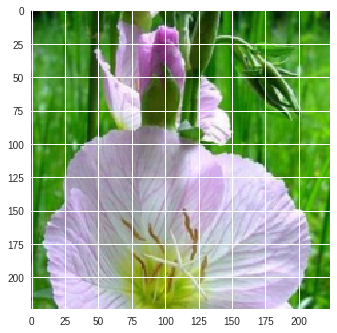

In [0]:
imshow(process_image(valid_dir + '/1/image_06758.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx

c2x = model.class_to_idx

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [0]:
!ls -al flower_data/valid/10/

total 164
drwxr-xr-x   2 root root  4096 Jan 15  2018 .
drwxr-xr-x 104 root root  4096 Jan 15  2018 ..
-rwxr-xr-x   1 root root 39849 Feb 19  2009 image_07094.jpg
-rwxr-xr-x   1 root root 32080 Feb 19  2009 image_07101.jpg
-rwxr-xr-x   1 root root 41720 Feb 19  2009 image_07102.jpg
-rwxr-xr-x   1 root root 39621 Feb 19  2009 image_07107.jpg


In [0]:
#Implement the function to predict the class from an image file
img = (valid_dir + '/10/image_07094.jpg')
val1, val2 = predict(img, model)

print(val1)
print(val2)

tensor([[0.6839, 0.2079, 0.0909, 0.0133, 0.0018]], device='cuda:0')
tensor([[ 77,  80,  71,   7, 101]], device='cuda:0')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
#Display an image along with the top 5 classes

def check_result(path):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1

    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    
    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    #Convert probabilities into CPU
    
    a = np.array(probabilities[0][0].cpu())
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0].cpu())]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

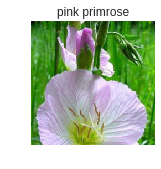

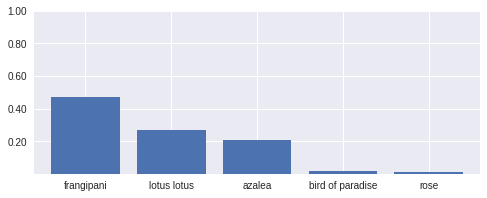

In [0]:
path = valid_dir + '/1/image_06758.jpg'
check_result(path)